<h1 style="text-align: center;">DeepONet</h1>

#### DeepONet for ODE

In this presentation, we will explore DeepONet, as introduced in the paper Learning Nonlinear Operators via DeepONet Based on the Universal Approximation Theorem of Operators by Lu Lu, Pengzhan Jin, Guofei Pang, Zhongqiang Zhang, and George Em Karniadakis. To ensure clarity and respect for the original work, we will first consider the antiderivative operator as a means of solving a linear ordinary differential equation (ODE)

$$\frac{\partial s(x)}{\partial x} = u(x), \quad s(0) = 0.$$
Then we have 
$$s(x) = \int_0^{x}u(\tau)d\tau$$

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from gstools import SRF, Exponential, Matern
from gstools.random import MasterRNG
from scipy import integrate
import time

In [2]:
no_points = 100
no_ufunction = 110

In [3]:
x = np.linspace(0, 1, no_points)

In [4]:
seed = MasterRNG(45)
def generate_function(x, model_type='Exponential'):
    
    if model_type == 'Gaussian':
        model = Gaussian(dim=1, var=1, len_scale=0.2)
    elif model_type == 'Exponential':
        model = Exponential(dim=1, var=1, len_scale=0.2)
    elif model_type == 'Matern':
        model = Matern(dim=1, var=1, len_scale=0.2, nu=1.5)  

    srf = SRF(model, seed=seed())
    f = srf.structured([x])
    return f

In [5]:
Ufunction = np.zeros((no_points,no_ufunction))
for i in range(no_ufunction):
    Ufunction[:,i] = generate_function(x)

In [6]:
def antiderivative(ufunction):
    Sfunction = np.zeros_like(ufunction)
    Sfunction[0]=0
    for i in range(1, len(ufunction)):
        Sfunction[i]= integrate.simpson(ufunction[:i+1],x=x[:i+1])
    return Sfunction

In [7]:
Sfunction = np.zeros((no_points,no_ufunction))
for i in range(no_ufunction):
    Sfunction[:,i] = antiderivative(Ufunction[:,i])

We arrange the data as the form of following

<img src="deeponet.png" alt="My Image" width="800"/>
It is like providing the neural network with the structure of the function (parameter)  $u(x)$ based on the given grid points (x values). For each variable $x_i$,  the network outputs the corresponding value  $s_i$.
​
 

In [8]:
def arrange_Ufunction_x_S(no_points, no_ufunction, x, Ufunction, G_antideriv4Uf):
    # Create index arrays for Uf_G and G_G
    Uf_s = np.tile(Ufunction.T, (1, no_points)).reshape(no_points * no_ufunction, no_points)
    x_s = np.repeat(x.reshape(no_points, 1), no_ufunction, axis=1).T.flatten()[:, np.newaxis]
    S_s = Sfunction.T.flatten()[:, np.newaxis]

    return Uf_s, x_s, S_s

In [11]:
Uf_s, x_s, S_s = arrange_Ufunction_x_S(no_points, no_ufunction, x, Ufunction, Sfunction)

In [15]:
def data_split_loader(batch_size,no_points, no_ufunction, x, Ufunction, Sfunction, ratio=0.7):
    Uf_s, x_s, S_s = arrange_Ufunction_x_S(no_points, no_ufunction, x, Ufunction, Sfunction)

    train_size = int(len(Uf_s) * ratio)
    Uf_s_train, x_s_train, S_s_train = Uf_s[:train_size], x_s[:train_size], S_s[:train_size]
    Uf_s_test, x_s_test, S_s_test = Uf_s[train_size:], x_s[train_size:], S_s[train_size:]

    # Convert to TensorFlow tensors
    Uf_s_train = tf.convert_to_tensor(Uf_s_train, dtype=tf.float32)
    x_s_train = tf.convert_to_tensor(x_s_train, dtype=tf.float32)
    S_s_train = tf.convert_to_tensor(S_s_train, dtype=tf.float32)
    
    Uf_s_test = tf.convert_to_tensor(Uf_s_test, dtype=tf.float32)
    x_s_test = tf.convert_to_tensor(x_s_test, dtype=tf.float32)
    S_s_test = tf.convert_to_tensor(S_s_test, dtype=tf.float32)

    # Create TensorFlow datasets
    train_dataset = tf.data.Dataset.from_tensor_slices((Uf_s_train, x_s_train, S_s_train))
    test_dataset = tf.data.Dataset.from_tensor_slices((Uf_s_test, x_s_test, S_s_test))

    # Shuffle and batch the datasets
    train_dataloader = train_dataset.shuffle(buffer_size=len(Uf_s_train)).batch(batch_size)
    test_dataloader = test_dataset.shuffle(buffer_size=len(Uf_s_test)).batch(batch_size)

    return train_dataloader, test_dataloader

In [16]:
batch_size = 32
train_data, test_data = data_split_loader(batch_size,no_points, no_ufunction, x, Ufunction, Sfunction,ratio=0.7)

In [17]:

class DeepONet(tf.keras.Model):
    def __init__(self, neurons=40, branch_input=no_points, trunk_input=1, output_neurons=20):
        super(DeepONet, self).__init__()
        self.branch_input = branch_input
        self.trunk_input = trunk_input
        self.output_neurons = output_neurons
        self.neurons = neurons
        
        self.branch = self.branch_network()
        self.trunk = self.trunk_network()

    def branch_network(self):
        model = tf.keras.Sequential([
                tf.keras.layers.Input(shape=(self.branch_input,)),  # Define the input shape here
                tf.keras.layers.Dense(self.neurons, activation='relu'),
                tf.keras.layers.Dense(self.neurons, activation='relu'),
                tf.keras.layers.Dense(self.output_neurons)
                ])
        return model
        
    def trunk_network(self):
        model = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(self.trunk_input,)),  # Define the input shape here
            tf.keras.layers.Dense(self.neurons, activation='relu'),
            tf.keras.layers.Dense(self.neurons, activation='relu'),
            tf.keras.layers.Dense(self.output_neurons)
        ])
        return model
        
    def call(self, x1, x2):
        x1 = self.branch(x1)
        x2 = self.trunk(x2)
        # Perform the element-wise multiplication and sum along the feature dimension
        x = tf.reduce_sum(x1 * x2, axis=1)  # Equivalent to torch.einsum("bi, bi->b", x1, x2)
        x = tf.expand_dims(x, axis=1)  # Equivalent to torch.unsqueeze(x, 1)
        return x

In [18]:
model = DeepONet(neurons=40, branch_input= no_points, trunk_input=1,output_neurons=20)

In [19]:
model.summary()

Model: "deep_o_net"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 20)             │         6,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 20)             │         2,540 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,040 (35.31 KB)

 Trainable params: 9,040 (35.31 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
def loss_function(y_pred, y):
    return tf.reduce_mean(tf.square(y_pred - y))

In [21]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [22]:
start_time = time.time()
train_data = train_data.prefetch(buffer_size=tf.data.AUTOTUNE)

@tf.function
def train_step(Uf_batch, x_batch, G_batch):
    with tf.GradientTape() as tape:
        y_pred = model(Uf_batch, x_batch)
        l = loss_function(y_pred, G_batch)
    gradients = tape.gradient(l, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return l

train_losses = []
epochs = 2000

for epoch in range(epochs):
    l_total = 0
    for Uf_batch, x_batch, G_batch in train_data:
        l = train_step(Uf_batch, x_batch, G_batch)
        l_total += l.numpy()

    l_total /= len(train_data)
    train_losses.append(l_total)

    if epoch % 20 == 0:
        print(f"Epoch: {epoch}/{epochs}, Loss: {l_total}")
end_time = time.time()
print(end_time-start_time)

Epoch: 0/2000, Loss: 0.011340643776797098
Epoch: 20/2000, Loss: 0.0005386340936898985
Epoch: 40/2000, Loss: 0.00033885639053875683
Epoch: 60/2000, Loss: 0.00026452707819794245
Epoch: 80/2000, Loss: 0.00025302503988967
Epoch: 100/2000, Loss: 0.00021111221492041242
Epoch: 120/2000, Loss: 0.00023743829328718469
Epoch: 140/2000, Loss: 0.0001656629896108776
Epoch: 160/2000, Loss: 0.00017550867911320976
Epoch: 180/2000, Loss: 0.0001400274642599704
Epoch: 200/2000, Loss: 0.00015117810054933865
Epoch: 220/2000, Loss: 0.00014065288605820097
Epoch: 240/2000, Loss: 9.866451602866312e-05
Epoch: 260/2000, Loss: 0.00011540411953274276
Epoch: 280/2000, Loss: 0.00011620547395589359
Epoch: 300/2000, Loss: 0.00010378375852997878
Epoch: 320/2000, Loss: 0.00012407065544898634
Epoch: 340/2000, Loss: 0.00012600759417869255
Epoch: 360/2000, Loss: 0.00011152684909201719
Epoch: 380/2000, Loss: 0.00010624216896101651
Epoch: 400/2000, Loss: 0.00011084690045227714
Epoch: 420/2000, Loss: 9.413814299311913e-05
Epoc

#### DeepONet for 1d heat equation

Similarly, we consider the 1 d heat equation
$$\frac{\partial u(x,t)}{\partial t} - \alpha \frac{\partial^2 u}{\partial x^2} = 0, \quad u(0,x) = u_{ini}(x).$$
Here the DeepONet for the heat equation is similar as above ODE, the only difference is the input dimension for th trunk net is 2 not 1.

In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from gstools import SRF,Gaussian, Exponential, Matern
from gstools.random import MasterRNG
from scipy import integrate
from scipy.linalg import solve
import torch.optim as optim
import time

In [5]:
mx = 40
mt = 50
n = 10
x_range = 1
y_range = 2

In [6]:
x = np.linspace(0, x_range, mx)
y = np.linspace(0, y_range, mt)

alpha = 0.01

dx = abs(x[0]-x[1])
dt = abs(y[0]-y[1])

r = alpha * dt / dx**2  # Stability factor (for implicit method)
print(r)

0.6208163265306123


In [7]:
seed = MasterRNG(45)
def generate_function(x, model_type='Gaussian'):
    
    if model_type == 'Gaussian':
        model = Gaussian(dim=1, var=50, len_scale=0.6)
    elif model_type == 'Exponential':
        model = Exponential(dim=1, var=50, len_scale=0.6)
    elif model_type == 'Matern':
        model = Matern(dim=1, var=50, len_scale=0.2, nu=1.5)  

    srf = SRF(model, seed=seed())
    f = srf.structured([x])
    return f

In [8]:
U_in = np.zeros((mx,n))

for nn in range(n):
    x_values = generate_function(x)
    U_in[:,nn] = x_values

In [9]:
X, Y = np.meshgrid(y,x)
print(X.shape)
print(Y.shape)

(40, 50)
(40, 50)


In [10]:
print(U_in.shape)

(40, 10)


In [11]:
S = np.zeros((mx,mt,n))
#S = U
for t in range(mt):
    S[:,t,:] = U_in

print(S[:,0,0])

[ 0.39588062  1.29230929  2.22946714  3.19851283  4.19019273  5.19494608
  6.2030125   7.20454043  8.1896951   9.14876462 10.07226287 10.95102813
 11.77631616 12.53988692 13.23408404 13.8519063  14.38707054 14.83406566
 15.18819736 15.44562342 15.6033796  15.65939615 15.61250518 15.46243921
 15.20982119 14.85614659 14.40375795 13.85581251 13.21624351 12.48971585
 11.68157661 10.79780117  9.84493553  8.83003549  7.76060315  6.64452153
  5.48998759  4.30544435  3.09951259  1.88092242]


In [12]:
A = np.zeros((mx, mx))
for i in range(1, mx-1):
    A[i, i-1] = -r
    A[i, i]   = 1 + 2*r
    A[i, i+1] = -r

# Boundary conditions in matrix form
A[0, 0] = A[-1, -1] = 1

for d in range(n):
    for t in range(0, mt-1):
        b = S[:,t,d]
        # Apply boundary conditions
        b[0] = S[0,t,d]
        b[-1] = S[-1,t,d]
        # Solve the linear system A*u^{n+1} = b
        u = solve(A, b)

        S[:,t+1,d] = u

print(S[:,:,0].shape)

(40, 50)


(40, 50)
(40, 50)


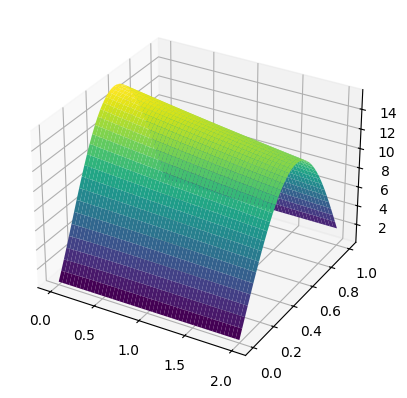

In [13]:
X, Y = np.meshgrid(y,x)
print(X.shape)
print(Y.shape)
fig = plt.figure()
ax = fig.add_subplot(111, projection ='3d')
ax.plot_surface(X, Y, S[:,:,0], cmap='viridis')

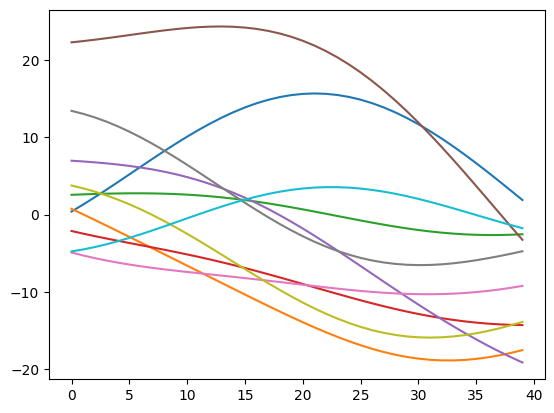

In [14]:
plt.plot(U_in)

In [15]:
x.shape, y.shape, S.shape, U_in.shape

((40,), (50,), (40, 50, 10), (40, 10))

In [16]:
def arrange_data(mx=mx, mt=mt, n=n, U_in=U_in, S=S):
    us = np.zeros((mx*mt*n, mx))
    xs = np.zeros((mx*mt*n, 2))
    ss = np.zeros((mx*mt*n, 1))
    count = 0
    for i in range(n):
        for k in range(mt):
            for j in range(mx):
                us[count,:] = U_in[:,i]
                xs[count] = [x[j],y[k]]
                ss[count] = S[j, k, i]
                count = count+1
                
    return us, xs, ss

In [17]:
us,xs,ss = arrange_data()

In [18]:
us.shape, xs.shape, ss.shape

((20000, 40), (20000, 2), (20000, 1))

In [22]:
def data_split_loader(batch_size, mx=mx, mt=mt, n=n, S=S, ratio=0.8):
    us, xs, ss = arrange_data(mx,mt,n,U_in,S)

    train_size = int(len(us) * ratio)
    us_train = us[:train_size]
    xs_train = xs[:train_size]
    ss_train = ss[:train_size]
    
    us_test = us[train_size:]
    xs_test = xs[train_size:]
    ss_test = ss[train_size:]


    # Convert to TensorFlow tensors
    us_train = tf.convert_to_tensor(us_train, dtype=tf.float32)
    xs_train = tf.convert_to_tensor(xs_train, dtype=tf.float32)
    ss_train = tf.convert_to_tensor(ss_train, dtype=tf.float32)
    
    us_test = tf.convert_to_tensor(us_test, dtype=tf.float32)
    xs_test = tf.convert_to_tensor(xs_test, dtype=tf.float32)
    ss_test = tf.convert_to_tensor(ss_test, dtype=tf.float32)

    # Create TensorFlow datasets
    train_dataset = tf.data.Dataset.from_tensor_slices((us_train, xs_train, ss_train))
    test_dataset = tf.data.Dataset.from_tensor_slices((us_test, xs_test, ss_test))

    # Shuffle and batch the datasets
    train_dataloader = train_dataset.shuffle(buffer_size=len(us_train)).batch(batch_size)
    test_dataloader = test_dataset.shuffle(buffer_size=len(us_test)).batch(batch_size)

    return train_dataloader, test_dataloader

In [23]:
train_data, test_data = data_split_loader(batch_size=32, mx=mx, mt=mt, n=n, S=S, ratio=0.8)

In [24]:
for u_in_, x_, s_ in train_data:
    print(u_in_.shape, x_.shape, s_.shape )
    break

(32, 40) (32, 2) (32, 1)


In [25]:
class DeepONet(tf.keras.Model):
    def __init__(self, neurons=60, branch_input=mx, trunk_input=2, output_neurons=40):
        super(DeepONet, self).__init__()
        self.branch_input = branch_input
        self.trunk_input = trunk_input
        self.output_neurons = output_neurons
        self.neurons = neurons
        
        self.branch = self.branch_network()
        self.trunk = self.trunk_network()

    def branch_network(self):
        model = tf.keras.Sequential([
                tf.keras.layers.Input(shape=(self.branch_input,)),  # Define the input shape here
                tf.keras.layers.Dense(self.neurons, activation='relu'),
                tf.keras.layers.Dense(self.neurons, activation='relu'),
                tf.keras.layers.Dense(self.output_neurons)
                ])
        return model

    def trunk_network(self):
        model = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(self.trunk_input,)),  # Define the input shape here
            tf.keras.layers.Dense(self.neurons, activation='relu'),
            tf.keras.layers.Dense(self.neurons, activation='relu'),
            tf.keras.layers.Dense(self.output_neurons)
        ])
        return model
        
    def call(self, x1, x2):
        x1 = self.branch(x1)
        x2 = self.trunk(x2)
        # Perform the element-wise multiplication and sum along the feature dimension
        x = tf.reduce_sum(x1 * x2, axis=1)  # Equivalent to torch.einsum("bi, bi->b", x1, x2)
        x = tf.expand_dims(x, axis=1)  # Equivalent to torch.unsqueeze(x, 1)
        return x

In [26]:
model = DeepONet(neurons=60, branch_input = mx, trunk_input= 2, output_neurons =40)

In [27]:
model.summary()

Model: "deep_o_net"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 40)             │         8,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 40)             │         6,280 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,840 (57.97 KB)

 Trainable params: 14,840 (57.97 KB)

 Non-trainable params: 0 (0.00 B)

In [28]:
def loss_function(y_pred, y):
    return tf.reduce_mean(tf.square(y_pred - y))

In [29]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [ ]:
start_time = time.time()
train_data = train_data.prefetch(buffer_size=tf.data.AUTOTUNE)

@tf.function
def train_step(us_batch, x_batch, s_batch):
    with tf.GradientTape() as tape:
        y_pred = model(us_batch, x_batch)
        l = loss_function(y_pred, s_batch)
    gradients = tape.gradient(l, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return l

train_losses = []
epochs = 600

for epoch in range(epochs):
    l_total = 0
    for us_batch, x_batch, s_batch in train_data:
        l = train_step(us_batch, x_batch, s_batch)
        l_total += l.numpy()

    l_total /= len(train_data)
    train_losses.append(l_total)

    if epoch % 20 == 0:
        print(f"Epoch: {epoch}/{epochs}, Loss: {l_total}")
end_time = time.time()
print(end_time-start_time)

Epoch: 0/600, Loss: 0.037274831500835715
Epoch: 20/600, Loss: 0.011343537881271914
Epoch: 40/600, Loss: 0.012813355969265104


In [ ]:
plt.plot(train_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")